## Initializing Stuff 

In [1]:
import cv2

import math
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import count
from abc import ABC, abstractmethod
from typing import Any, List, Union
from collections import namedtuple, deque, OrderedDict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gymnasium as gym
from gymnasium import Env
from gymnasium.wrappers import (
    FrameStack,
    ResizeObservation,
    TransformObservation
)

c:\Users\ijaje\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

## Define Replay Memory

In [3]:
Transition = namedtuple('Transition',
    ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
        

## Define Q-function approximator networks.

In [61]:
class FeedForwardDQN(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super().__init__()
        self.hidden1 = nn.Linear(inp_dim, 64)
        self.hidden2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, out_dim)

        # Helps in creating clones
        self.inp_args = [inp_dim, out_dim]

    def forward(self, state):
        # Only if x is not already a tensor
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)

        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))

        return self.output(x)


In [ ]:
class ConvDQN(nn.Module):
    def __init__(self, inp_shape, out_dim):
        super().__init__()
        self.inp_shape = inp_shape

        self.conv = nn.Sequential(
            nn.Conv2d(inp_shape[1], 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Dropout(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Dropout(),
            nn.Conv2d(64, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Dropout(),
            nn.Flatten()
        )

        conv_op_shape = self._conv_op_shape()

        self.hidden = nn.Linear(conv_op_shape, int(conv_op_shape/2))
        self.output = nn.Linear(int(conv_op_shape/2), out_dim)

        # Helps in creating clones
        self.inp_args = [inp_shape, out_dim]

    def _conv_op_shape(self):
        with torch.no_grad():
            x = torch.zeros(
                self.inp_shape,
                device=next(self.parameters()).device
            )
            x = self.conv(x)
        return x.shape[-1]

    def forward(self, state):
        # Convert to torch tensors
        if not isinstance(state, torch.Tensor):
            state = torch.as_tensor(state)

        # Scale pixel values between 0 and 1
        x = state/255 

        # Handle add the channel dim
        if len(x.shape) == 3:
            x = x.unsqueeze(1)

        x = self.conv(x)
        x = self.hidden(F.relu(x))

        return self.output(x)


## Define the Q-Learning Trainer

In [5]:
class QLearningTrainer(object):
    def __init__(self, env: Env, policy_net: nn.Module):
        self.env = env

        # if gpu is to be used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.policy_net = policy_net.to(self.device)
        # Clone the policy net
        self.target_net = type(policy_net)(*policy_net.inp_args).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
       
        # Cumulative reward of each episode
        self.reward_history: List[float] = list()
        # Number of time steps taken in each episode
        self.episode_durations: Union[List[int], List[float]] = list()
        # Record Epsilon values
        self.epsilon_vals: List[float] = list()

    def ep_greedy_policy(
        self,
        state,
        *,
        epsilon: float
    ):
        if self.env.np_random.uniform(0, 1) > epsilon:
            return self.greedy_policy(state), True

        else:
            return torch.tensor(
                [[self.env.action_space.sample()]],
                dtype=torch.long
            ), False

    def greedy_policy(self, state):
        with torch.no_grad():
            return self.policy_net(
                state.to(self.device)
            ).max(1)[1].reshape(1, 1).cpu()

    def _optimize(self, lr: float, gamma: float, batch_size: int):
        if len(self.memory) < batch_size:
            return

        transitions = self.memory.sample(batch_size)
        # Transpose the batch
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=self.device, dtype=torch.bool
        )

        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        ).to(self.device)

        state_batch = torch.cat(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        # Get the policy network's estimations of the current state's action values.
        st_action_values  = self.policy_net(state_batch).gather(1, action_batch)

        # Get the target network's estimations of the next state's action values.
        nx_st_action_values = torch.zeros((batch_size, 1), device=self.device)
        with torch.no_grad():
            nx_st_action_values[non_final_mask] = \
                self.target_net(non_final_next_states).max(1)[0].unsqueeze(1)

        target_st_action_values = (nx_st_action_values*gamma) + reward_batch

        # Compute Huber loss
        # We use Huber loss instead of MSE as it gives better stability
        # It behaves like MSE when the error is small and mae when it is large
        criterion = nn.SmoothL1Loss()
        loss = criterion(st_action_values, target_st_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

    def train(
        self,
        memory: ReplayMemory,
        *,
        num_episodes: int = 600,
        lr: float = 1e-4,
        gamma: float = .99,
        ep_min: float = .02,
        ep_max: float = .95,
        decay_rate: float = 8e-3,
        tau: float = 5e-3,
        batch_size: int = 16,
        quiet: bool = False,
        optimize_only_greedy: bool = False
    ):
        """Train the agent

        Args:
        num_episodes (int, optional): Defaults to 600.
        lr (float, optional): The learning rate for the otimizer. Defaults to 1e-4.
        gamma (float, optional): The discount factor. Defaults to .9.
        ep_min (float, optional): Min exploration probability. Defaults to .08.
        ep_max (float, optional): Max exploration probability. Defaults to 1.
        decay_rate (float, optional): Epsilon decay rate. Defaults to 8*1e-3.
        tau (float, optional): The update rate of the target network. Defaults to .005
        optimize_only_greedy (bool, optional): Only run optimization when the action is greedy.

        Returns:
        List[float]: Reward earned in every episode.
        """
        self.memory = memory
        self.optimizer = optim.AdamW(
            self.policy_net.parameters(),
            lr=lr,
            amsgrad=True
        )

        prog_bar = tqdm(range(num_episodes), desc='Train Episode', disable=quiet)
        for episode in prog_bar:
            epsilon = ep_min + (ep_max-ep_min)*np.exp(-decay_rate*episode)

            total_reward = 0
            state, _ = self.env.reset(seed=88)
            state = torch.tensor(
                state, dtype=torch.float32
            ) # no need to unsqueeze, the state is rank 2 already

            # Run the episode
            for t in count():
                action, is_greedy = self.ep_greedy_policy(
                    state,
                    epsilon=epsilon
                )

                next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([[reward]])
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(
                        next_state, dtype=torch.float32
                    ) # no need to unsqueeze, the state is rank 2 already

                total_reward += reward
                # Store the transition in memory
                self.memory.push(state, action, next_state, reward)

                state = next_state

                # Otimize the DQN
                # Otimize the DQN
                if is_greedy or (not optimize_only_greedy):
                    self._optimize(lr, gamma, batch_size)

                    # Soft update of the target network's weights
                    # θ′ ← τ θ + (1 −τ )θ′
                    target_net_state_dict = self.target_net.state_dict()
                    policy_net_state_dict = self.policy_net.state_dict()

                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = \
                            policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)

                    self.target_net.load_state_dict(target_net_state_dict)

                if done:
                    self.epsilon_vals.append(epsilon)
                    self.episode_durations.append(t+1)
                    # self.plot_durations()
                    self.reward_history.append(total_reward.item())
                    # self.plot_rewards()
                    prog_bar.set_postfix_str(
                        f"episode_duration: {t+1}; cumulative_reward: {total_reward.item()}"
                    )
                    break

    def evaluate(self, num_episodes: int = 10**2, quiet: bool = False):
        """Evaluate the agent

        Args:
            num_episodes (int): Defaults to 10**2.

        Returns:
            List[float]: Reward earned in every episode.
        """
        prog_bar = tqdm(range(num_episodes), desc='Eval Episode: ', disable=quiet)
        for _ in prog_bar:
            total_reward = 0
            state, _ = self.env.reset(seed=88)
            state = torch.tensor(
                state, dtype=torch.float32
            ) # no need to unsqueeze, the state is rank 2 already

            # Run the episode
            for t in count():
                action = self.greedy_policy(state)

                next_state, reward, terminated, truncated, _ = self.env.step(action.item())
                reward = torch.tensor([[reward]])
                done = terminated or truncated

                if terminated:
                    next_state = None
                else:
                    next_state = torch.tensor(
                        next_state, dtype=torch.float32
                    ) # no need to unsqueeze, the state is rank 2 already

                total_reward += reward

                state = next_state

                if done:
                    self.episode_durations.append(t+1)
                    # self.plot_metrics()
                    self.reward_history.append(total_reward)
                    prog_bar.set_postfix_str(
                        f"episode_duration: {t+1}; cumulative_reward: {total_reward.item()}"
                    )
                    break

    def plot_metrics(self, show_result=False):
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        rewards_t = torch.tensor(self.reward_history, dtype=torch.float)

        plt.rcParams["figure.figsize"] = (30,12)
        plt.rcParams["font.size"] = 22
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig, (ax3) = plt.subplots()

        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Duration (in Time Steps)')
        ax1.plot(durations_t.numpy(), label='Duration', linewidth=2)
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            ax1.plot(means.numpy(), label='Running Average Duration', linewidth=2)
            ax1.legend()
            ax1.grid(True)
        ax3.plot(self.epsilon_vals, label='Epsilon', linewidth=2)
        ax3.legend()
        ax3.grid(True)
        ax3.set_xlabel('Episode')
        ax3.set_ylabel('Epsilon')

        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Cumulative Reward (per Episode)')
        ax2.plot(rewards_t.numpy(), label='Reward', linewidth=2)
        # Take 100 episode averages and plot them too
        if len(rewards_t) >= 100:
            means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            ax2.plot(means.numpy(), label='Running Average Reward', linewidth=2)
        ax2.legend()
        ax2.grid(True)

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())


## Make the Env Wrappers

In [ ]:
from a1_env import DeterministicGridEnvironment

class A1EnvWrapper(DeterministicGridEnvironment):
    def reset(self, seed=None, options=None):
        obs, info = super().reset(seed, options)

        state = obs['agent']
        # Convert 2-d state index to flat index
        # flat_idx = curr_row*num_cols+curr_col
        state = torch.tensor([state[0]*self.size+state[1]], dtype=torch.long)

        # The reward situation
        situation = torch.from_numpy(obs['reward']).unsqueeze(0)

        # Set the `state`-th element of the `situation` tensor at 0.5
        situation[0, state] = .5

        return situation, info
        
    def step(self, action):
        obs, reward, terminated, truncated, info = super().step(action)

        state = obs['agent']
        # Convert 2-d state index to flat index
        # flat_idx = curr_row*num_cols+curr_col
        state = torch.tensor([state[0]*self.size+state[1]], dtype=torch.long)

        # The reward situation
        situation = torch.from_numpy(obs['reward']).unsqueeze(0)

        # Set the `state`-th element of the `situation` tensor at 0.5
        situation[0, state] = .5

        return situation, reward, terminated, truncated, info


## Train DQN Agent

### Grid World Env

In [ ]:
# Initialize the agent and the env
a1env = A1EnvWrapper(size=6, render_mode='rgb_array', max_time_steps=40)

In [ ]:
memory = ReplayMemory(int(1e4))
policy_net = FeedForwardDQN(a1env.size**2, a1env.action_space.n)
qtrainer = QLearningTrainer(a1env, policy_net)

qtrainer.train(memory, num_episodes=2048, batch_size=64, lr=1e-3, tau=5e-4)

print('Complete')

In [ ]:
qtrainer.plot_metrics(show_result=True)
plt.show()

#### Evaluate

In [ ]:
qtrainer = QLearningTrainer(a1env, policy_net)
qtrainer.evaluate(num_episodes=200)
qtrainer.plot_metrics(show_result=True)
plt.show()

In [ ]:
torch.save(policy_net,'m44_ijajahme_assignment2_part2_dqn_gridworld.pickle')

### CartPole-v1 environment

In [ ]:
cartenv = gym.make("CartPole-v1")
# Transform the obs space
cartenv = TransformObservation(cartenv, lambda obs: np.expand_dims(obs, axis=0))

policy_net = FeedForwardDQN(cartenv.observation_space.shape[0], cartenv.action_space.n)
qtrainer = QLearningTrainer(cartenv, policy_net)

memory = ReplayMemory(int(1e4))
qtrainer.train(memory, num_episodes=1024, lr=1e-4, batch_size=128, tau=5e-3)


In [ ]:
qtrainer.plot_metrics(show_result=True)
plt.show()

#### Evaluate

In [ ]:
qtrainer = QLearningTrainer(cartenv, policy_net)
qtrainer.evaluate(num_episodes=100)
qtrainer.plot_metrics(show_result=True)
plt.show()

In [ ]:
torch.save(policy_net,'m44_ijajahme_assignment2_part2_dqn_cartpole.pickle')

### Lunar Lander Environment

In [ ]:
landenv = gym.make("LunarLander-v2")
# Transform the obs space
landenv = TransformObservation(landenv, lambda obs: np.expand_dims(obs, axis=0))

policy_net = FeedForwardDQN(landenv.observation_space.shape[0], landenv.action_space.n)
qtrainer = QLearningTrainer(landenv, policy_net)

memory = ReplayMemory(int(1e5))
qtrainer.train(memory, num_episodes=1224, lr=1e-4, batch_size=64, tau=1e-3)

In [ ]:
qtrainer.plot_metrics(show_result=True)
plt.show()

#### Evaluating Lunar Lander

In [ ]:
qtrainer = QLearningTrainer(landenv, policy_net)
qtrainer.evaluate(num_episodes=100)
qtrainer.plot_metrics(show_result=True)
plt.show()

In [ ]:
torch.save(policy_net,'m44_ijajahme_assignment2_part2_dqn_lunarlander.pickle')

### Pong-v5

In [ ]:
# pongenv = TransformObservation(
#     FrameStack(
#         ResizeObservation(
#             gym.make('PongDeterministic-v4', obs_type='grayscale'),
#             84
#         ),
#         4
#     ),
#     lambda x: np.expand_dims(x, 0)
# )

In [ ]:
# policy_net = ConvDQN((1, 4, 84, 84), pongenv.action_space.n)
# qtrainer = QLearningTrainer(pongenv, policy_net)

# memory = ReplayMemory(int(1e4))
# qtrainer.train(memory, num_episodes=2048, lr=1e-3, batch_size=64, tau=5e-4)

In [ ]:
# qtrainer.plot_metrics(show_result=True)
# plt.show()

#### Evaluate

In [ ]:
# qtrainer = QLearningTrainer(cartenv, policy_net)
# qtrainer.evaluate(num_episodes=300)
# qtrainer.plot_metrics(show_result=True)
# plt.show()

## Define the Double Q Learner

In [6]:
class DoubleQLearningTrainer(QLearningTrainer):
    def _optimize(self, lr: float, gamma: float, batch_size: int):
        if len(self.memory) < batch_size:
            return

        optimizer = optim.AdamW(
            self.policy_net.parameters(),
            lr=lr,
            amsgrad=True
        )

        transitions = self.memory.sample(batch_size)
        # Transpose the batch
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=self.device, dtype=torch.bool
        )

        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        ).to(self.device)

        state_batch = torch.cat(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        # Get the policy network's estimations of the current state's action values.
        st_action_values  = self.policy_net(state_batch).gather(1, action_batch)

        nx_st_action_values = torch.zeros((batch_size, 1), device=self.device)
        with torch.no_grad():
            # Get the maximum value action based on the `policy network`
            nx_st_policy_net_actions = self.policy_net(
                non_final_next_states
            ).max(1)[1].unsqueeze(1)
            # Get the target network's estimations of the next state's action values.
            nx_st_action_values[non_final_mask] = \
                self.target_net(non_final_next_states).gather(
                    1, nx_st_policy_net_actions
                )

        target_st_action_values = (nx_st_action_values*gamma) + reward_batch

        # Compute Huber loss
        # We use Huber loss instead of MSE as it gives better stability
        # It behaves like MSE when the error is small and mae when it is large
        criterion = nn.SmoothL1Loss()
        loss = criterion(st_action_values, target_st_action_values)

        # Optimize the model
        optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        optimizer.step()


## Train DDQN Agent

### Grid World Env

In [ ]:
# Initialize the agent and the env
a1env = A1EnvWrapper(size=6, render_mode='rgb_array', max_time_steps=40)

In [ ]:
memory = ReplayMemory(int(1e4))
policy_net = FeedForwardDQN(a1env.size**2, a1env.action_space.n)
qtrainer = DoubleQLearningTrainer(a1env, policy_net)

qtrainer.train(memory, num_episodes=2048, batch_size=64, lr=1e-3, tau=1e-3)

print('Complete')

In [ ]:
qtrainer.plot_metrics(show_result=True)
plt.show()

#### Evaluate

In [ ]:
qtrainer = DoubleQLearningTrainer(a1env, policy_net)
qtrainer.evaluate(num_episodes=1000)
qtrainer.plot_metrics(show_result=True)
plt.show()

In [ ]:
torch.save(policy_net,'m44_ijajahme_assignment2_part2_ddqn_gridworld.pickle')

### CartPole-v1 environment

In [43]:
class FeedForwardDQNCart(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super().__init__()
        self.hidden1 = nn.Linear(inp_dim, 64)
        self.hidden2 = nn.Linear(64, 64)
        self.output = nn.Linear(64, out_dim)

        # Helps in creating clones
        self.inp_args = [inp_dim, out_dim]

    def forward(self, state):
        # Only if x is not already a tensor
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, dtype=torch.float32)

        x = F.relu(self.hidden1(state))
        x = F.relu(self.hidden2(x))

        return self.output(x)


In [59]:
cartenv = gym.make("CartPole-v1")
# Transform the obs space
cartenv = TransformObservation(cartenv, lambda obs: np.expand_dims(obs, axis=0))

policy_net = FeedForwardDQNCart(cartenv.observation_space.shape[0], cartenv.action_space.n)
qtrainer = DoubleQLearningTrainer(cartenv, policy_net)

memory = ReplayMemory(int(1e4))
qtrainer.train(memory, num_episodes=1000, lr=1e-4, gamma=.92, batch_size=300, tau=1e-3,decay_rate=8e-3)


Train Episode: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s, episode_duration: 183; cumulative_reward: 183.0]


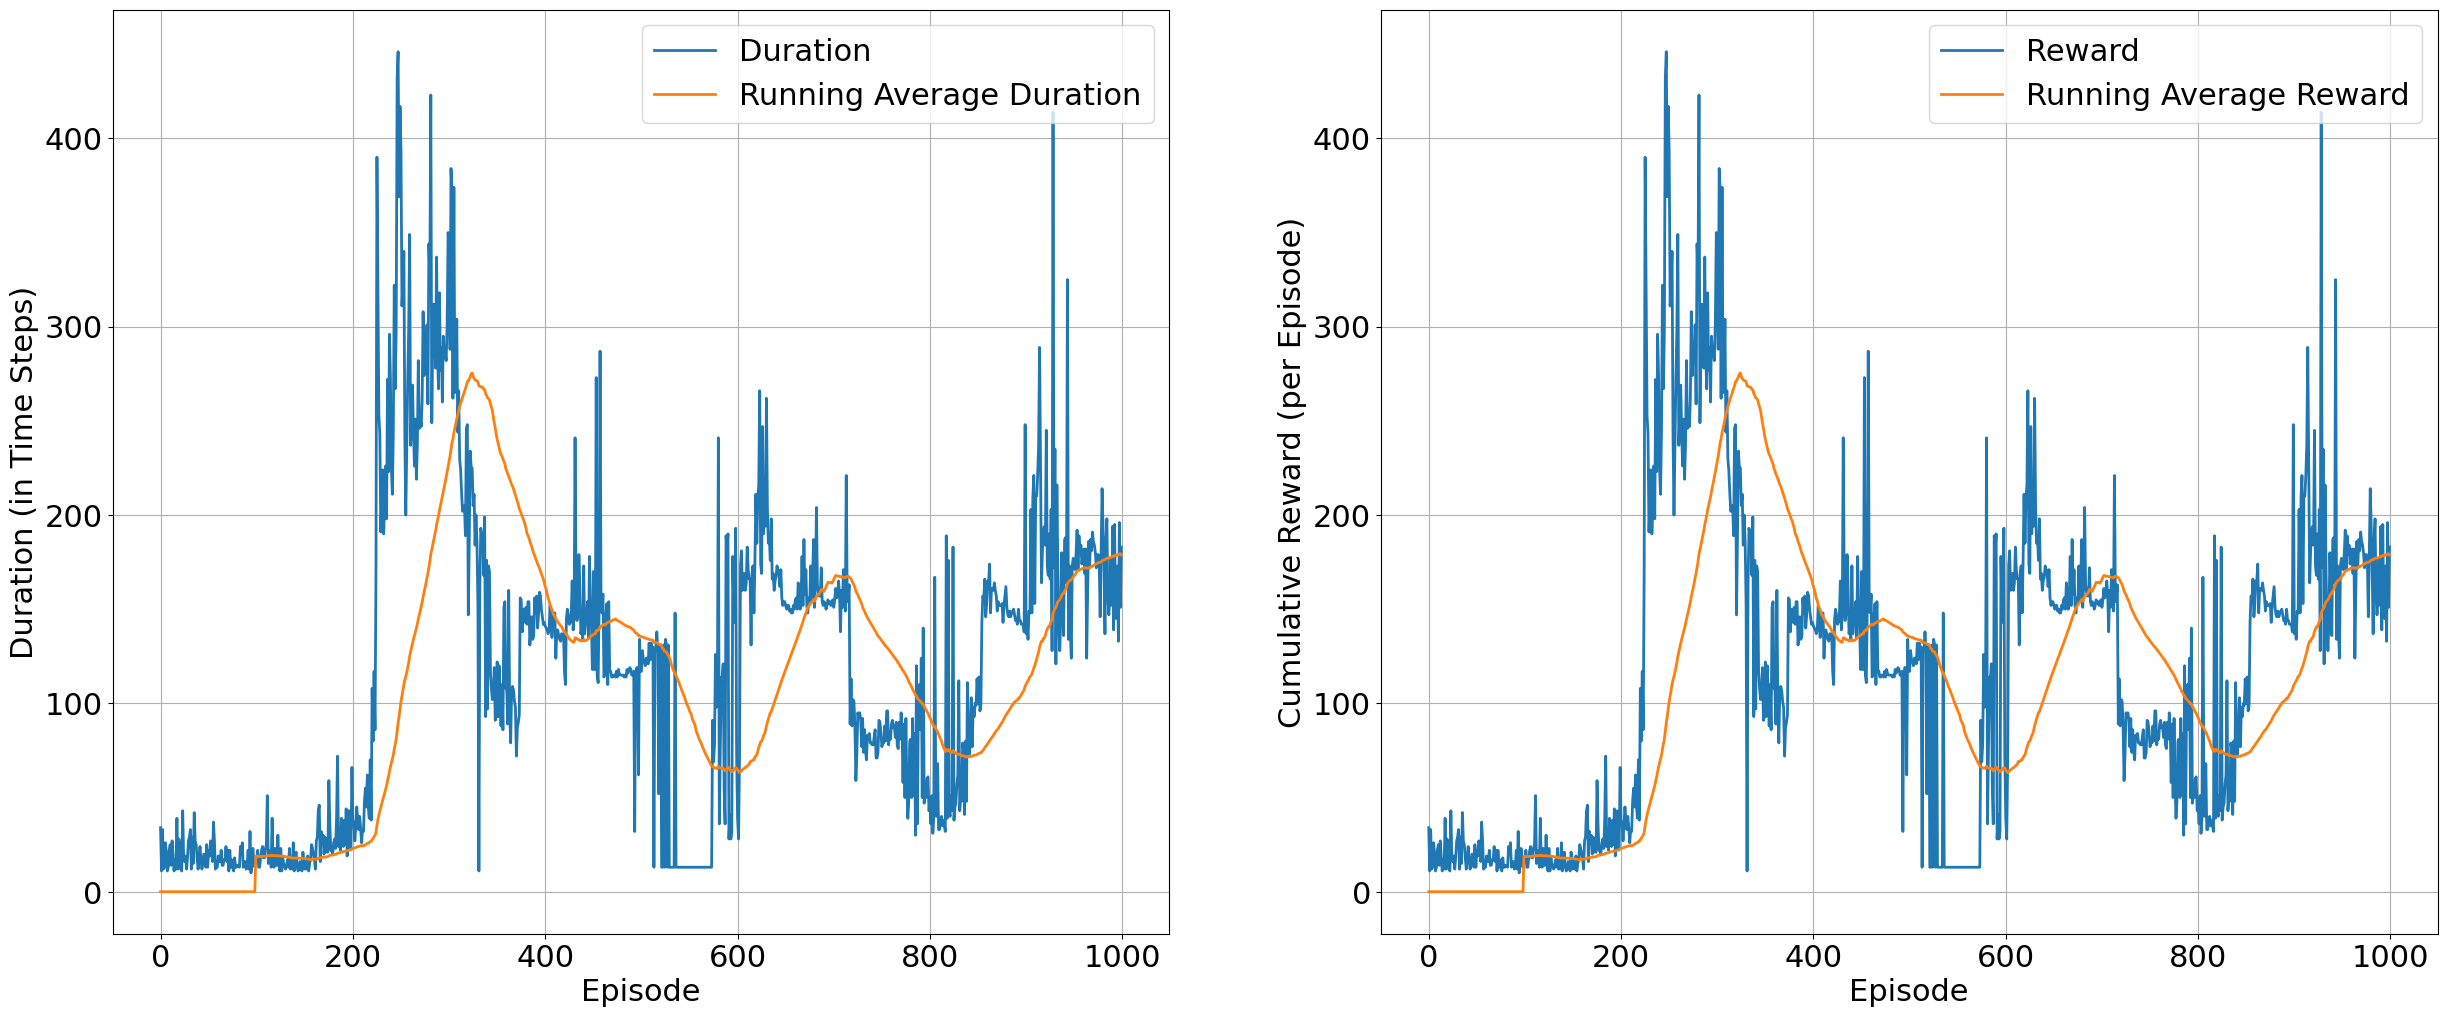

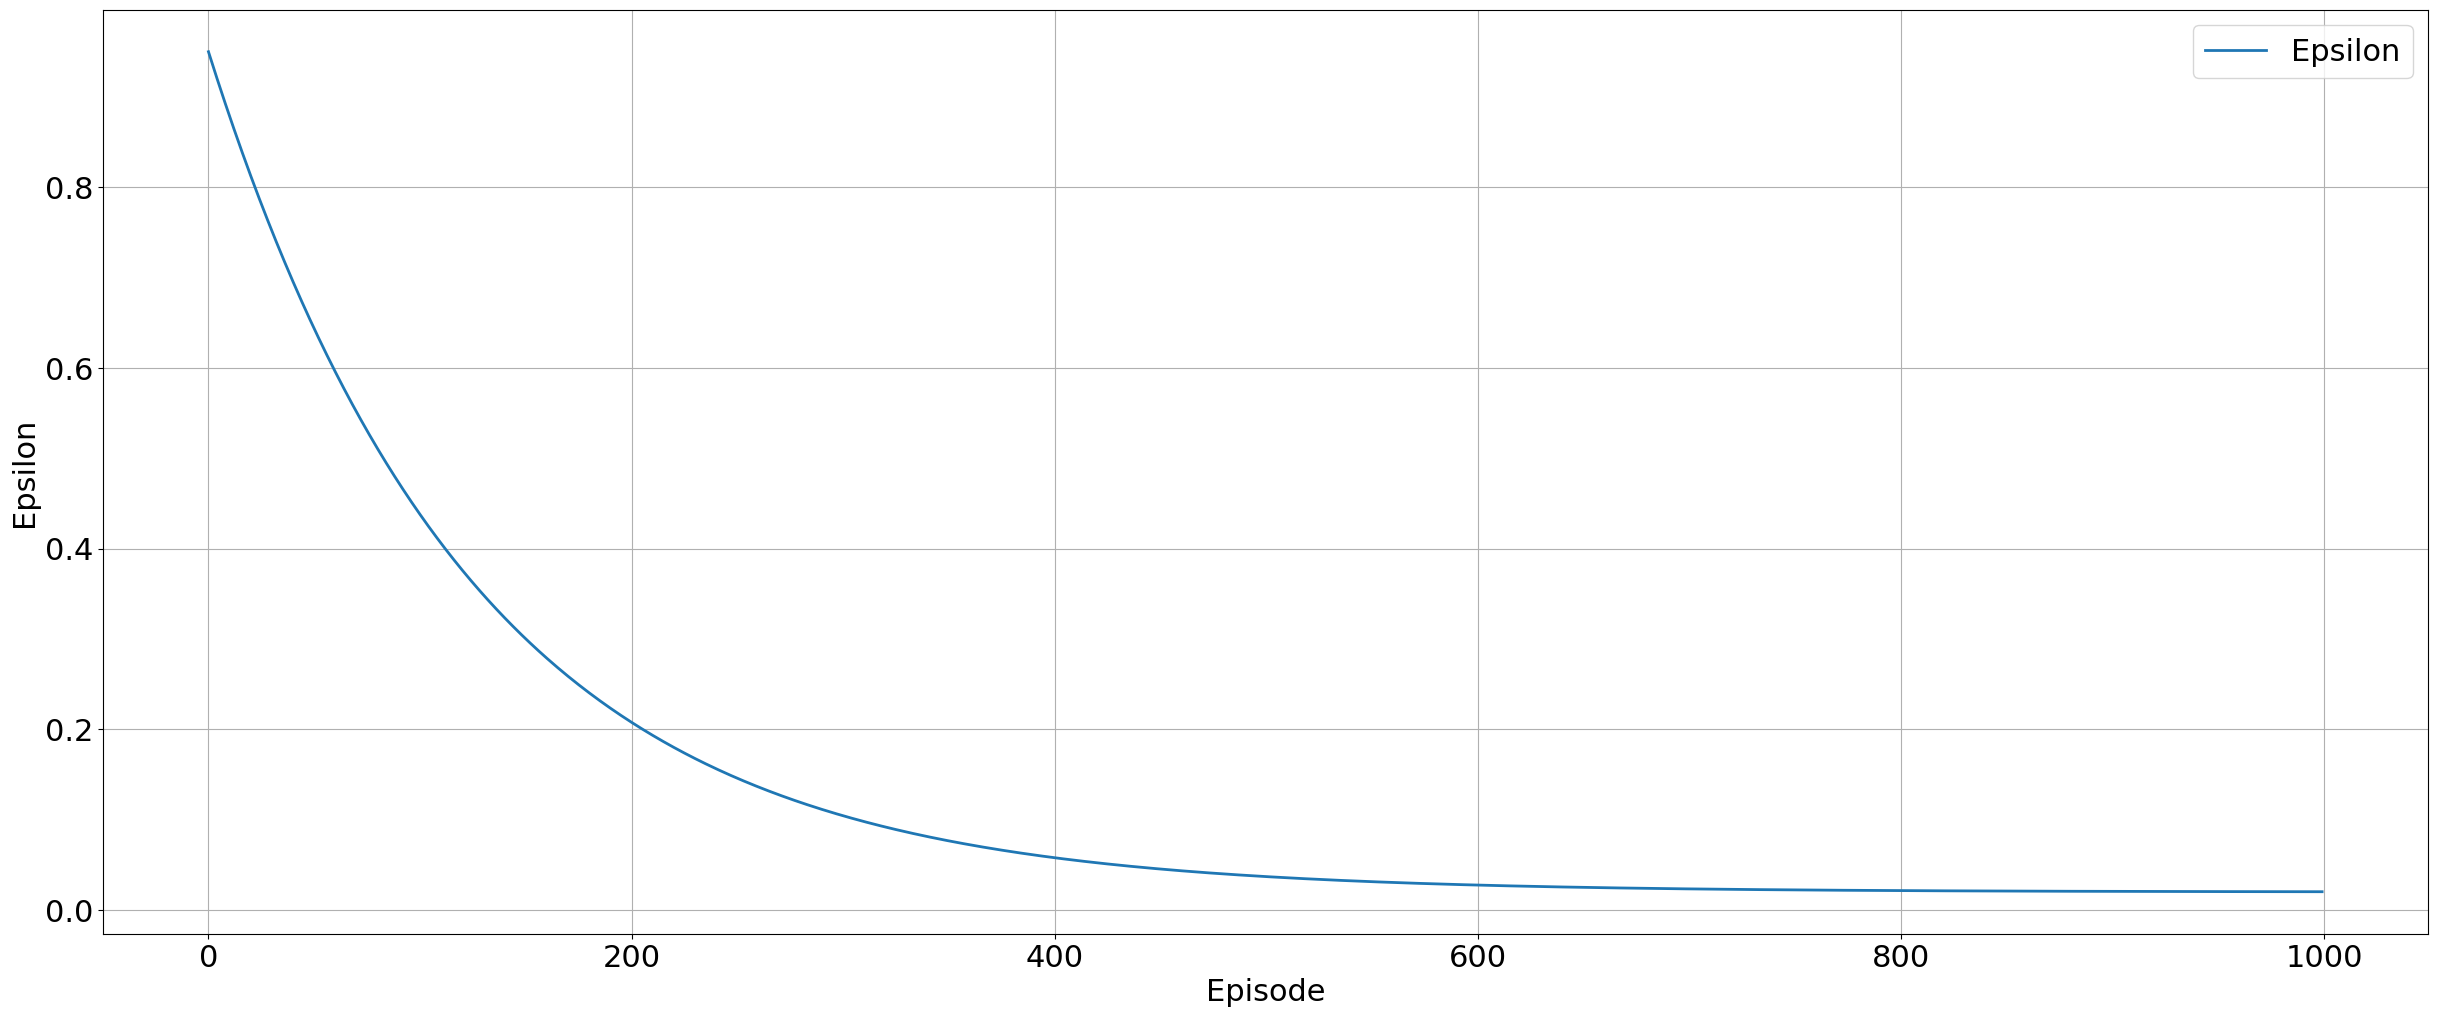

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

In [60]:
qtrainer.plot_metrics(show_result=True)
plt.show()

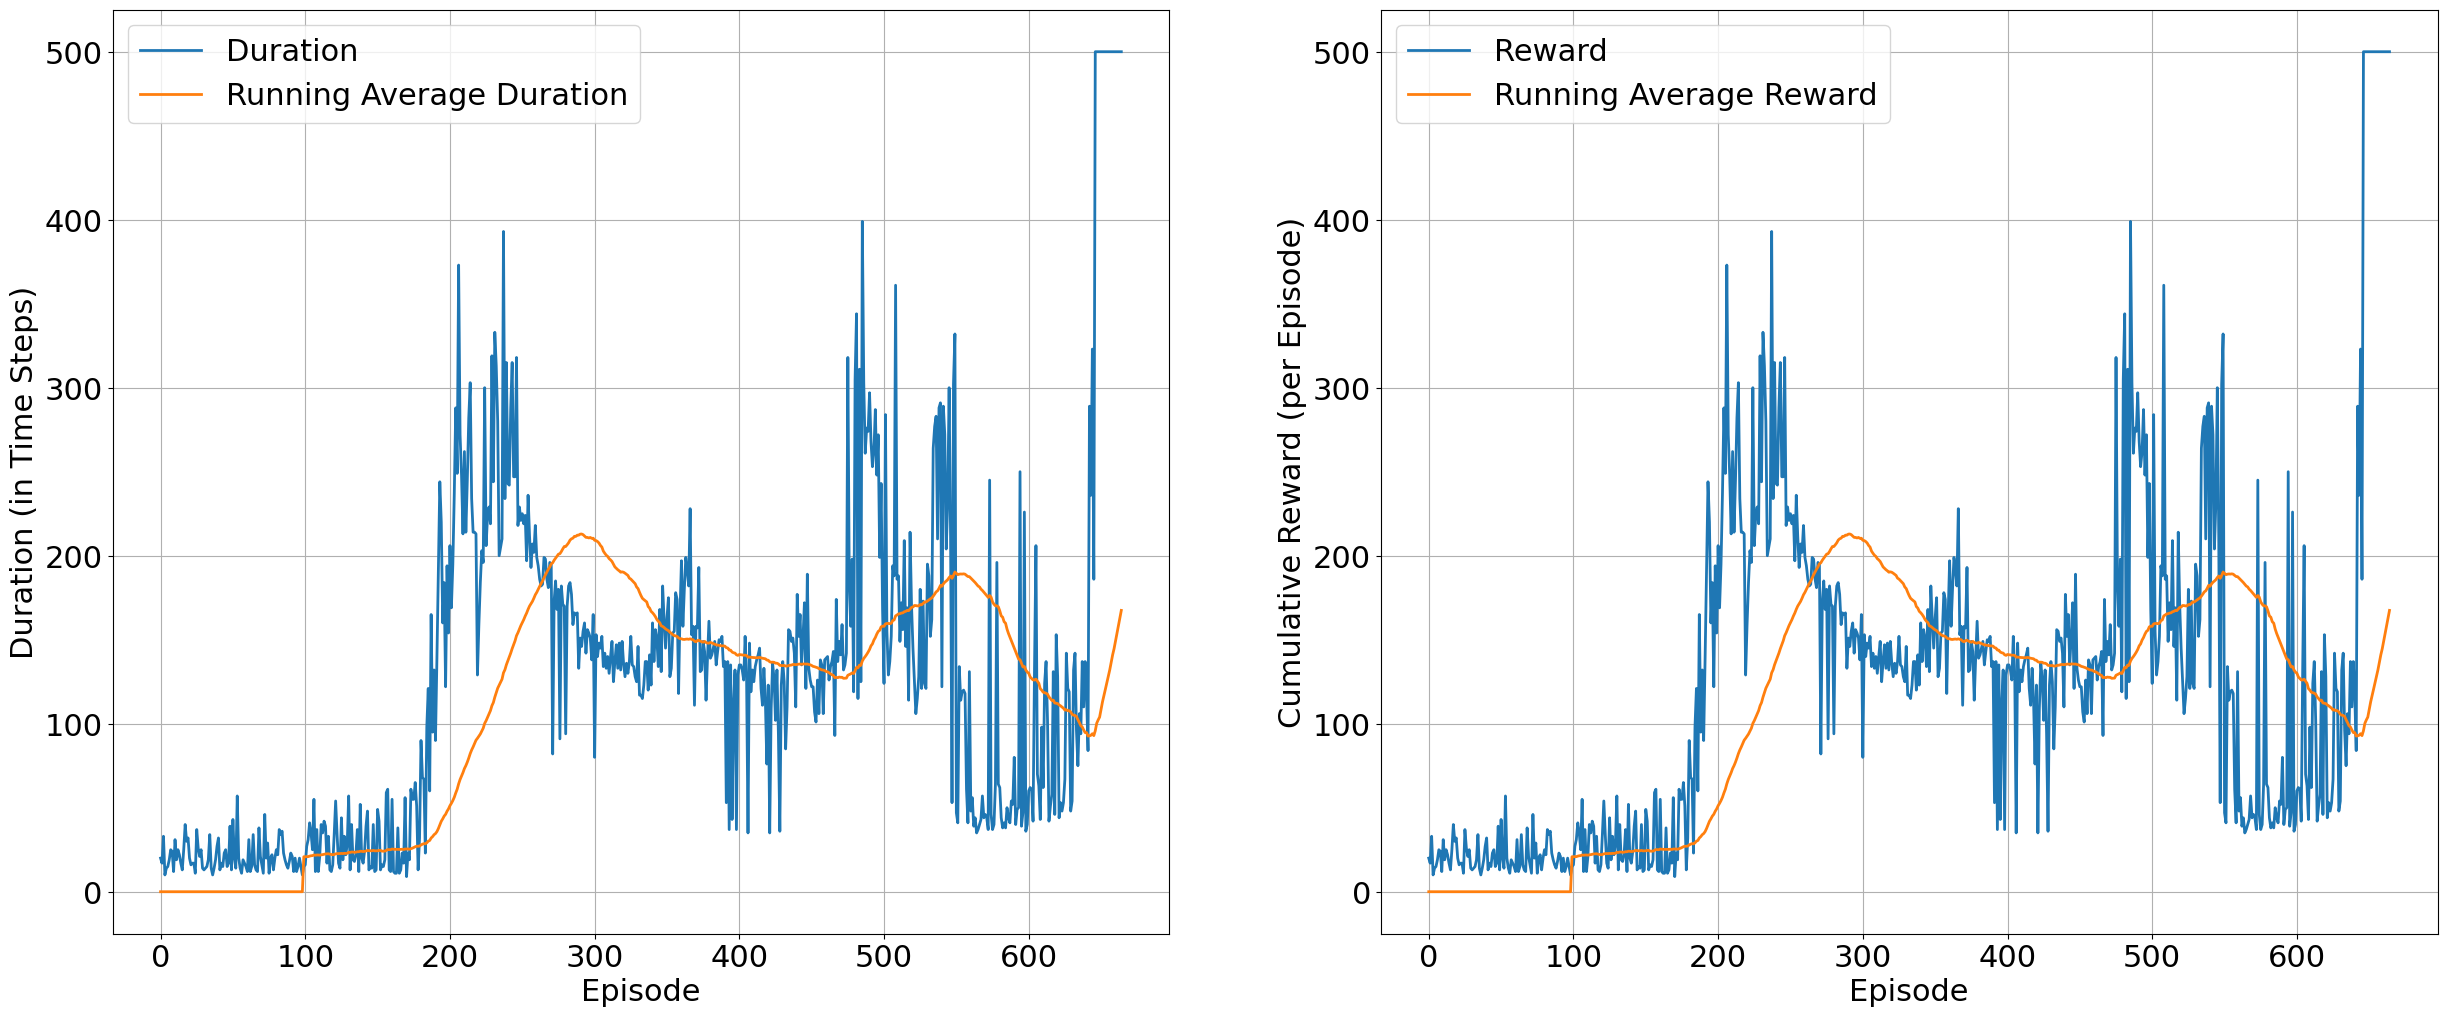

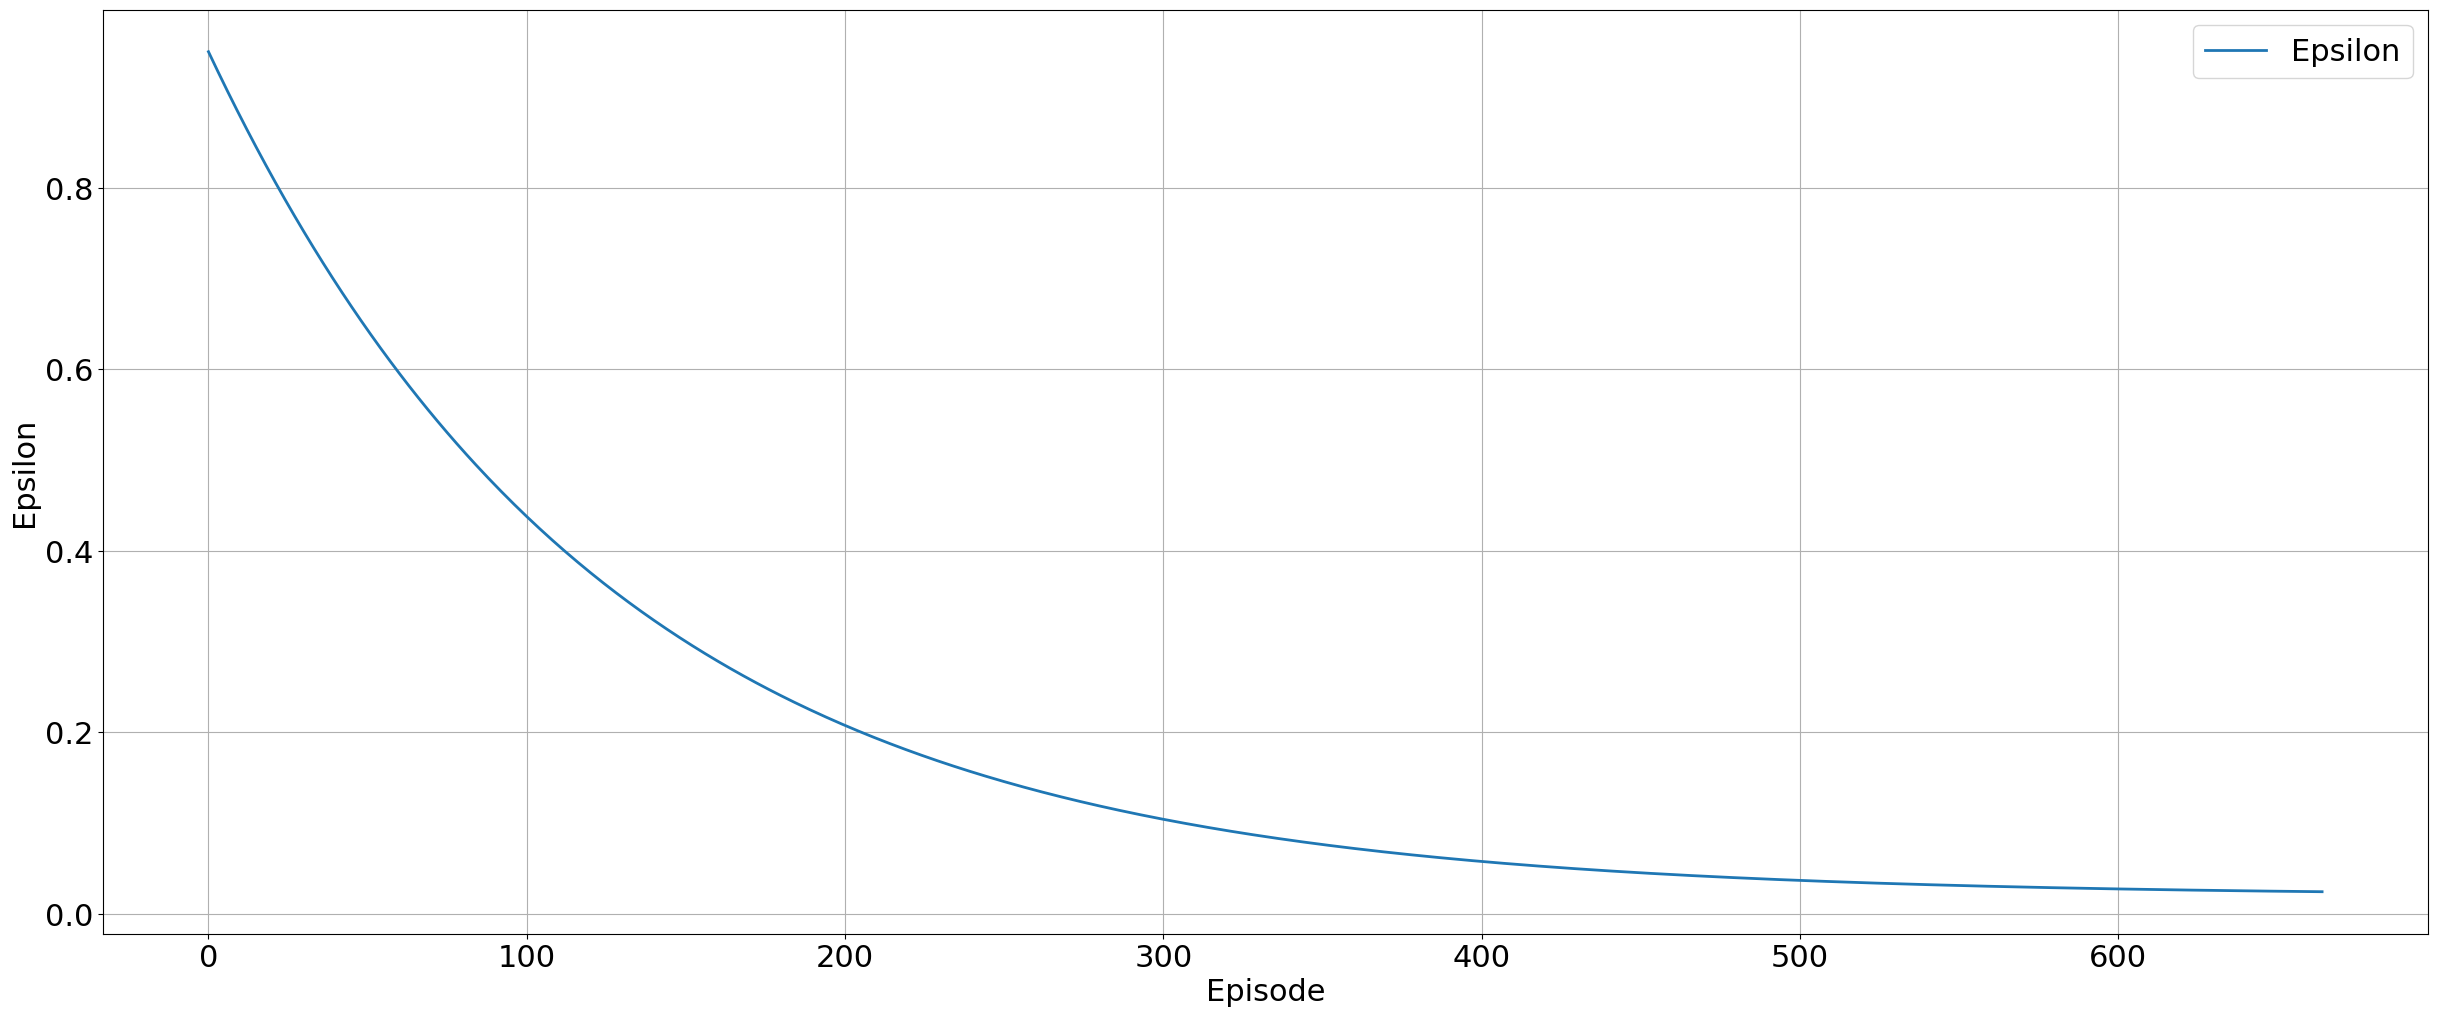

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

In [47]:
#qtrainer.plot_metrics(show_result=True)
#plt.show()

#### Evaluate

In [ ]:
qtrainer = DoubleQLearningTrainer(cartenv, policy_net)
qtrainer.evaluate(num_episodes=200)
qtrainer.plot_metrics(show_result=True)
plt.show()

In [54]:
torch.save(policy_net,'m44_ijajahme_assignment2_part2_ddqn_cartpole.pickle')

In [63]:
modelpol =torch.load('m44_ijajahme_assignment2_part2_ddqn_cartpole.pickle')

Eval Episode: 100%|██████████| 200/200 [00:27<00:00,  7.37it/s, episode_duration: 500; cumulative_reward: 500.0]


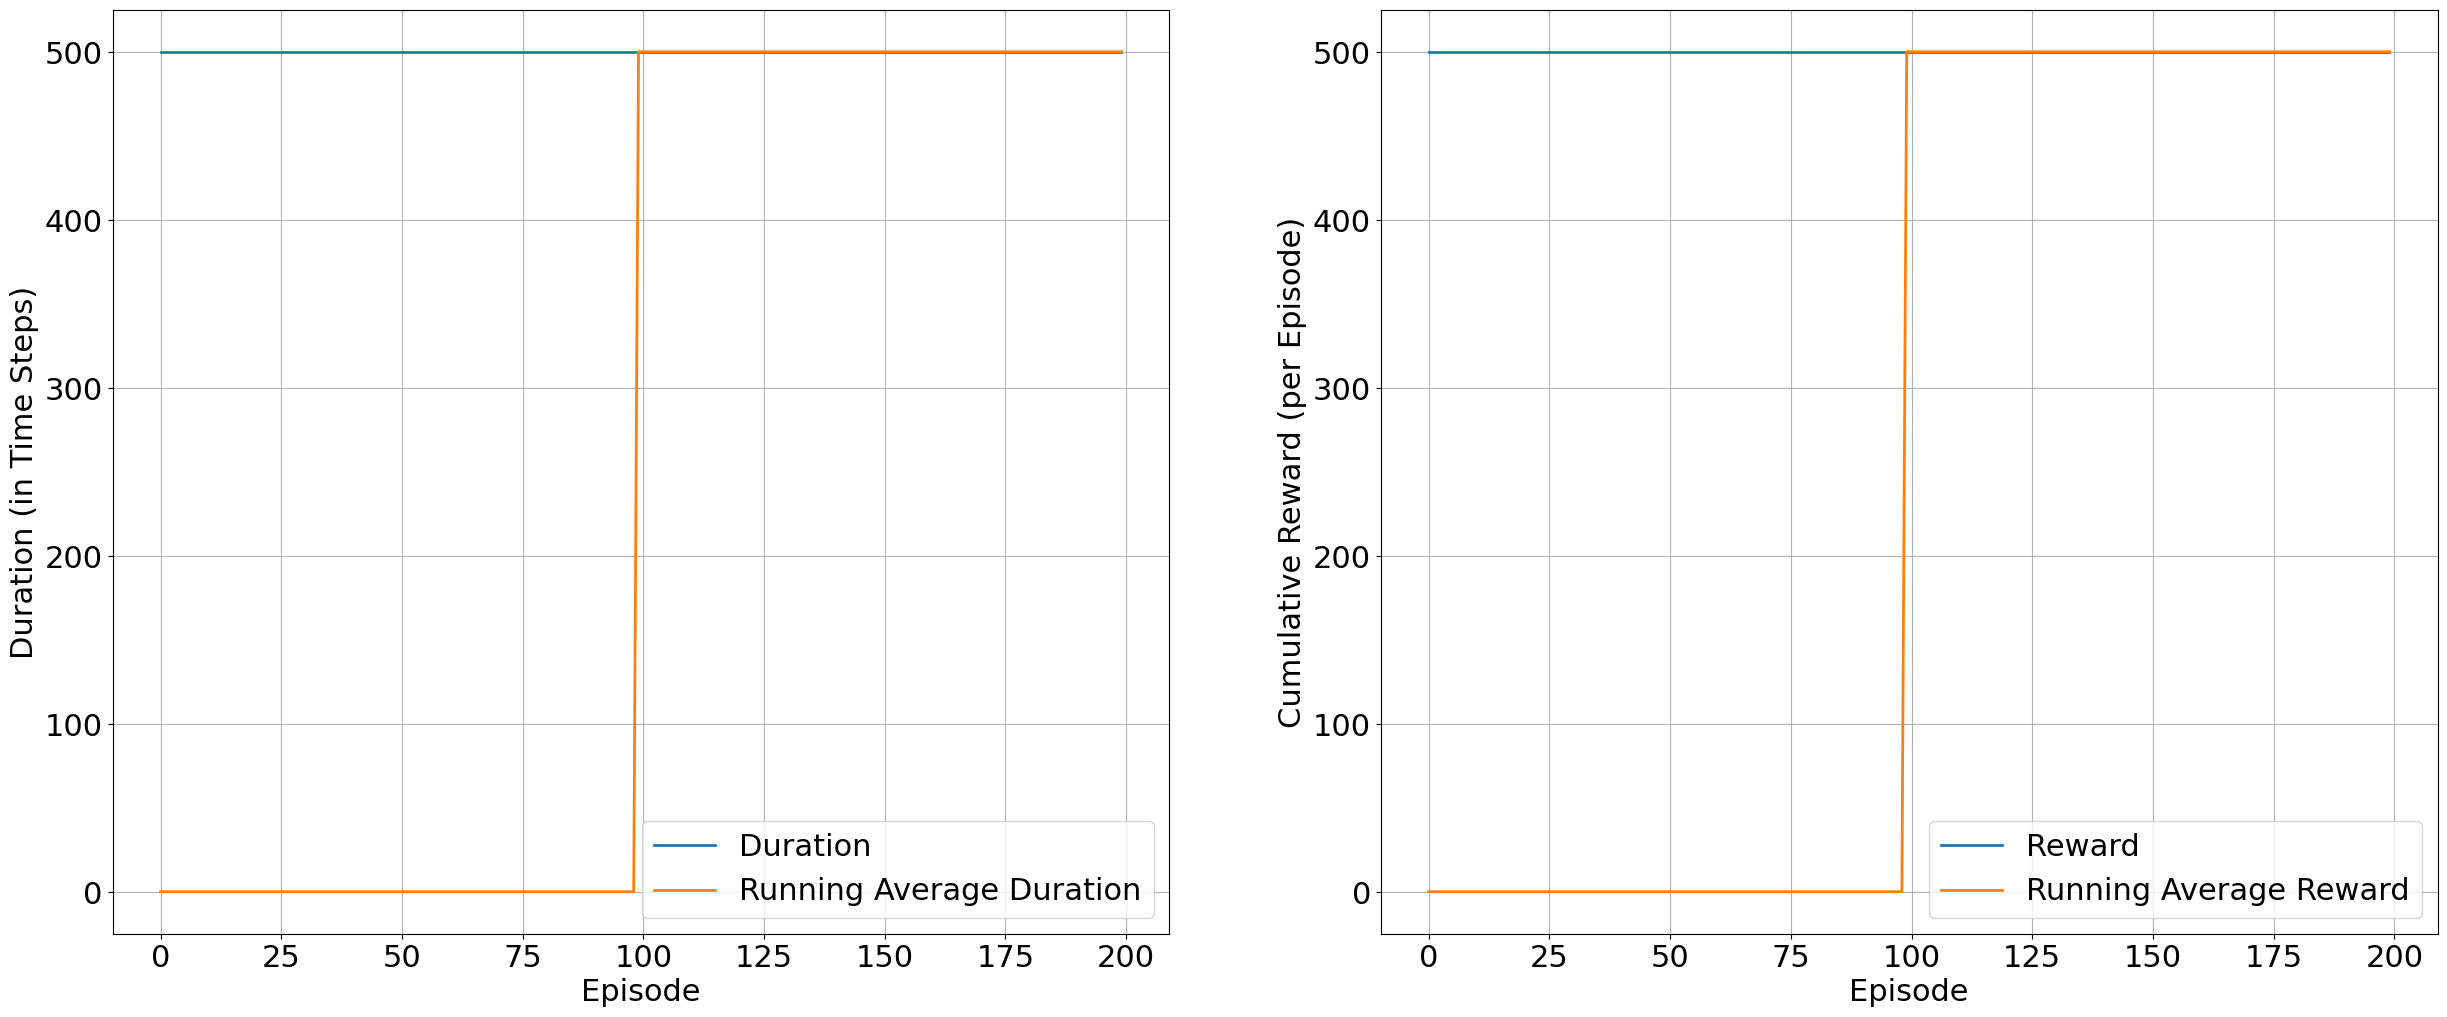

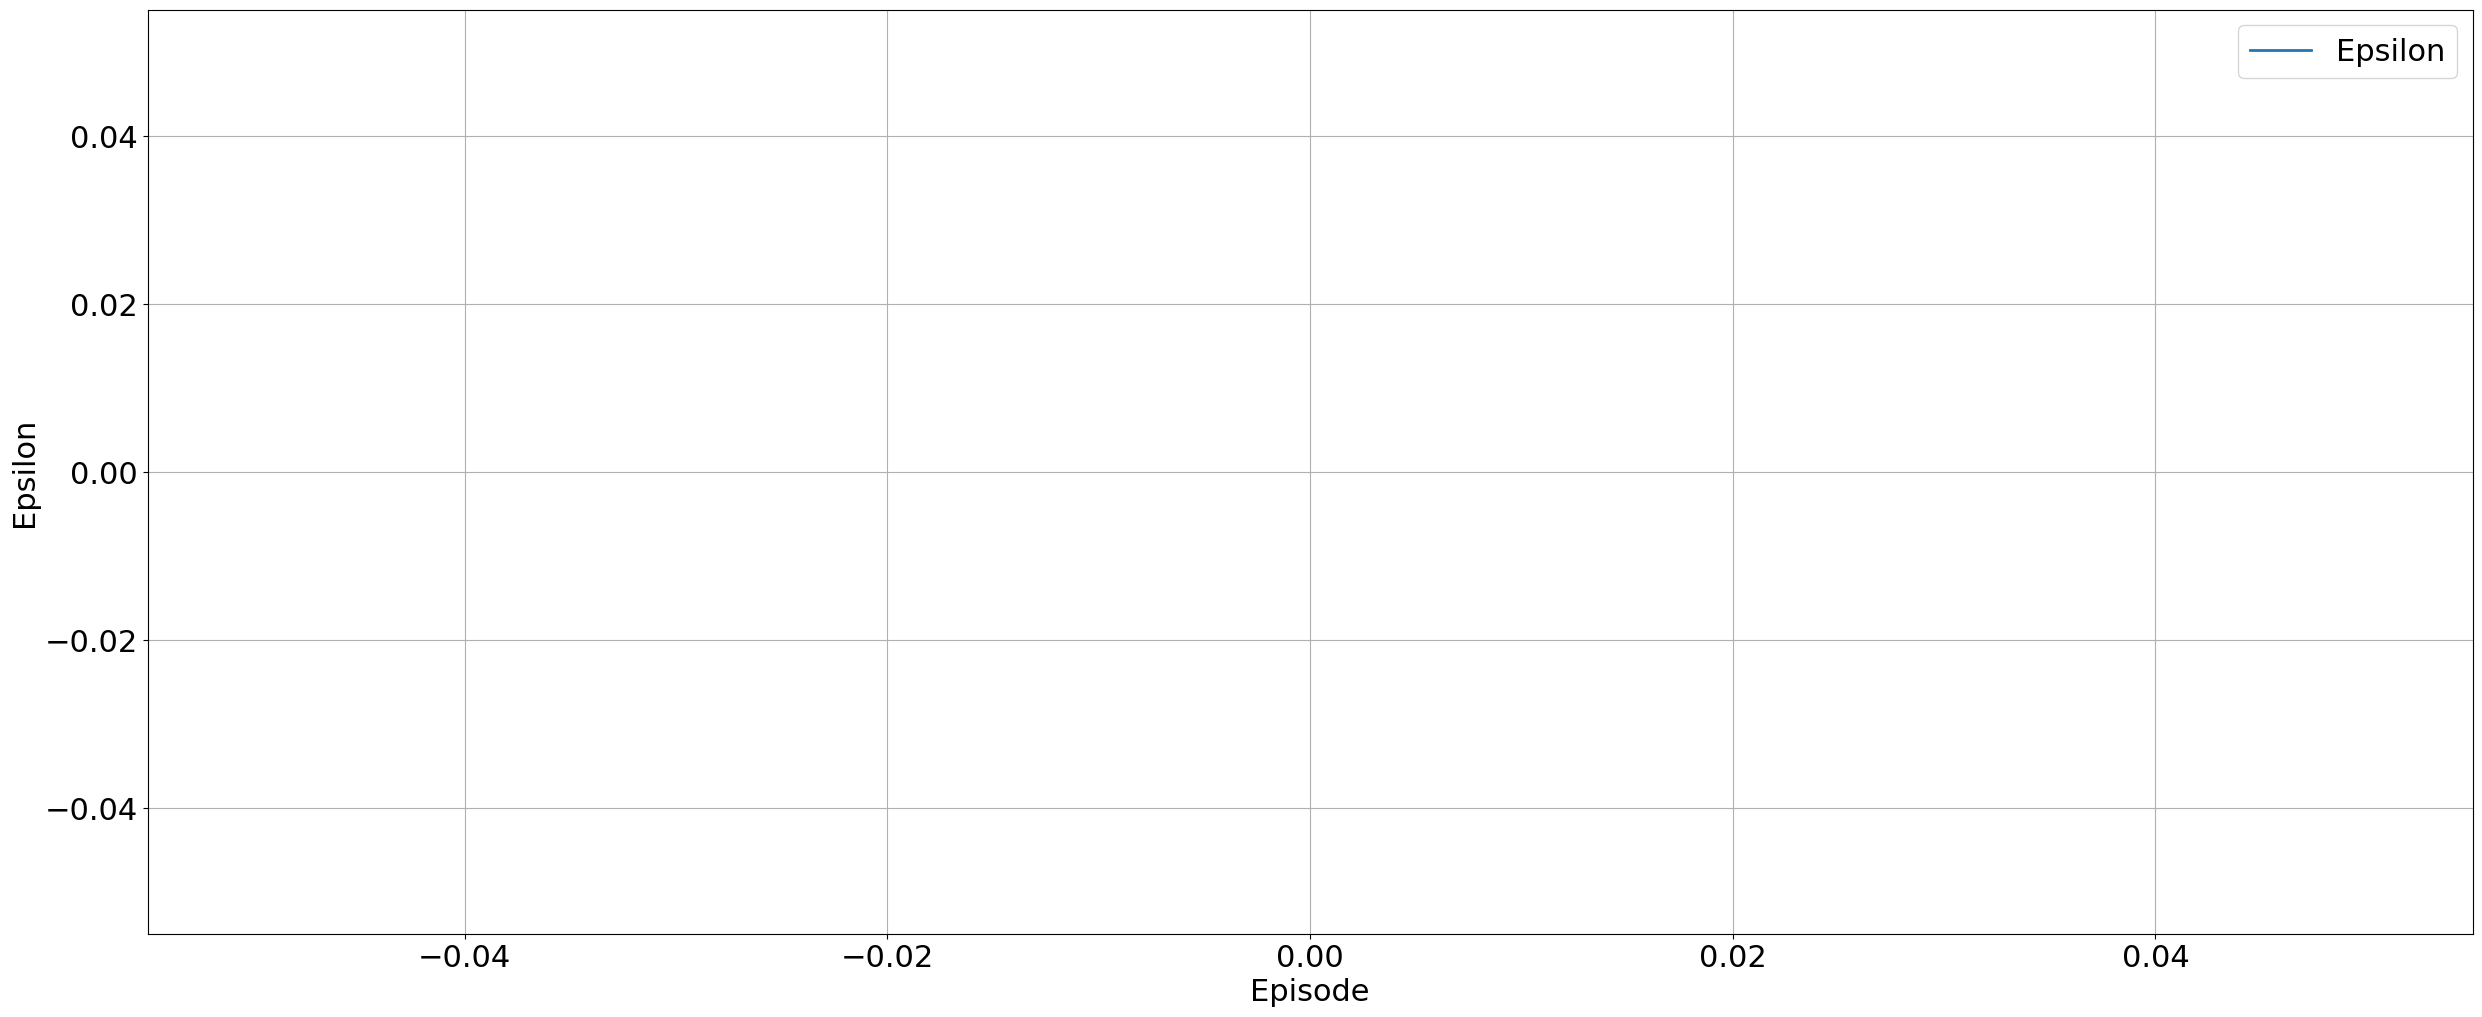

<Figure size 3000x1200 with 0 Axes>

<Figure size 3000x1200 with 0 Axes>

In [66]:
qtrainer = DoubleQLearningTrainer(cartenv, modelpol)
qtrainer.evaluate(num_episodes=200)
qtrainer.plot_metrics(show_result=True)
plt.show()

### Pong-v5

In [ ]:
# pongenv = TransformObservation(
#     FrameStack(
#         ResizeObservation(
#             GrayScaleObservation(
#                 gym.make('ALE/Pong-v5')
#             ),
#             84
#         ),
#         4
#     ),
#     lambda x: np.expand_dims(x, 0)
# )

In [ ]:
# policy_net = ConvDQN((1, 4, 84, 84), pongenv.action_space.n)
# qtrainer = QLearningTrainer(pongenv, policy_net)

# memory = ReplayMemory(int(1e4))
# qtrainer.train(memory, num_episodes=2048, lr=1e-3, batch_size=64, tau=5e-4)

In [ ]:
# qtrainer.plot_metrics(show_result=True)
# plt.show()

#### Evaluate

In [ ]:
# qtrainer = QLearningTrainer(cartenv, policy_net)
# qtrainer.evaluate(num_episodes=300)
# qtrainer.plot_metrics(show_result=True)
# plt.show()

### Lunar Lander Environment

In [62]:
landenv = gym.make("LunarLander-v2")
# Transform the obs space
landenv = TransformObservation(landenv, lambda obs: np.expand_dims(obs, axis=0))

policy_net = FeedForwardDQN(landenv.observation_space.shape[0], landenv.action_space.n)
qtrainer = DoubleQLearningTrainer(landenv, policy_net)

memory = ReplayMemory(int(1e5))
qtrainer.train(memory, num_episodes=1224, lr=1e-4, batch_size=64, tau=1e-3)

Train Episode:  11%|█▏        | 138/1224 [02:42<21:15,  1.17s/it, episode_duration: 1000; cumulative_reward: 114.98550390911112]  


KeyboardInterrupt: 

In [ ]:
qtrainer.plot_metrics(show_result=True)
plt.show()

#### Evaluating Lunar Lander

In [ ]:
qtrainer = QLearningTrainer(landenv, policy_net)
qtrainer.evaluate(num_episodes=100)
qtrainer.plot_metrics(show_result=True)
plt.show()

In [ ]:
torch.save(policy_net,'m44_ijajahme_assignment2_part2_ddqn_lunarlander.pickle')